# 3_Building footprints classification

Notebook for the 3rd pipeline - building footprints classification. In this notebook, we would like to test the 4-step process:
1. Generate additional features for clustering (rectangularity, polygon turning functions, proximity matrix)
1. Apply Tobler's geography law into clustering footprints (objects that are closed together --> same functions | near things are more relevant than far things)
    1. Proximity-based grouping footprints into building blocks (DBSCAN)
    1. Geography law apply: find footprints with similar shape (turning func, rectangularity) + size (total_area) ==> get majority of types
        1. Same building block
        1. Same area
    1. Apply statistical analysis results to categorize left-over footprints

## Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import glob
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

# from shapely import wkt
# from shapely.geometry import box, Polygon
# from geopandas import GeoDataFrame
# import hdbscan

In [3]:
# Self-made modules
import helpers as hp
import buildings_classification as bc

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Inputs
Define inputs path

In [5]:
buildings_int_path = '../data/02_intermediate/buildings_data/'
buildings_pri_path = '../data/03_primary/buildings_data/'

plz_ags_csv = '../data/01_raw/zuordnung_plz_ort_landkreis.csv'

# Demographics
ags_living_csv = '../data/01_raw/de_living_2019.csv'
ags_population_csv = '../data/01_raw/de_population_2019.csv'

# Community directory dataframe
GV_path = '../data/01_raw/GV/GV100AD_301120.asc'


Demographics data

In [6]:
ags_living = pd.read_csv(ags_living_csv, 
                         sep = ';', 
                         encoding = 'cp1250', 
                         dtype= {'1_Auspraegung_Code':str},
                         low_memory = False)
ags_population = pd.read_csv(ags_population_csv, 
                             sep = ';', 
                             dtype= {'1_Auspraegung_Code':str},
                             encoding = 'cp1250', 
                             low_memory = False)


Geographic data

In [7]:
# Contain local AGS codes (no regional)
plz_ags = pd.read_csv(plz_ags_csv, dtype= {'plz': str, 'ags': str})
plz_ags.shape

(12883, 4)



## Building blocks segmentation with (H)DBSCAN

In the paper ["Proximity-based grouping of buildings in urban blocks"](https://www.researchgate.net/publication/271901065_Proximity-based_grouping_of_buildings_in_urban_blocks_A_comparison_of_four_algorithms), the authors used 2 different approaches to evaluate 4 algorithms in clustering buildings into urban blocks. It concludes that DBSCAN (Density-based spatial clustering of applications with noise) together with ASCDT (An adaptive spatial clustering algorithm based on delaunay triangulation) performed best and their degree of complexity is not hard to implement. Thus, in this project, I implemented HDBSCAN - an extended version of DBSCAN to cluster our OSM building footprints.

### Reason not to use K-means (bonus)

When think of clustering, k-means usually pops right up as the first answer. As the algorithm itself, k-means is designed to minimize variance. 

Since the data is in latitude, longitude format ==> not **linear**, worst case is k-means will never converge (even with Haversine distance). To circumvent this problem, we should use an algorithm that can handle arbitrary distance functions, in particular geodetic distance functions such as Hierarchical clustering, PAM, CLARA, OPTICS and DBSCAN.

(inspired from [*])

### HDBSCAN
HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander[*]. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. Since clusters formed are not radius-based, they can be in non-circular format. Hence, it is more suitable for geo-analytics considering footprints boundaries are not in circular shape.And this is the algorithm we will use to group building footprints together.

Another good read to understand HDBSCAN better from [Author Name]'s article is here https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e


#### Parameters

More details on the official page [HERE](!https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)


For our project, we need to generate a **proximity matrix** for all building footprints in the area. Since we have already gathered and cleaned building objects data from ~10k municipalities in Germany (refer to the previous article), it is better to keep the building blocks grouping it the same granularity level (a.k.a municipality-level - AGS key)

There are 3 parameters for HDBSCAN we need to set:
*Epsilon* (ε)
*MinPts* 


We will start with the baseline from the paper with *ε* = 3 and *MinPts* = 2 then fine-tune them to get optimized values

> If “MinPts (minimum points)” = 2, any 2 or more points within the ε distance away from each other will be considered a cluster.





### References
[*] Ester, M. (2019). A density-based algorithm for discovering clusters in large spatial databases with noise. [online] Psu.edu. Available at: https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220 [Accessed 2 Jan. 2021].

[*] McInnes, L., Healy, J. and Astels, S. (2017). hdbscan: Hierarchical density based clustering. [online] ResearchGate. Available at: https://www.researchgate.net/publication/315508524_hdbscan_Hierarchical_density_based_clustering [Accessed 6 Jan. 2021].

[*] Clustering geo location coordinates (lat,long pairs (2014). Clustering geo location coordinates (lat,long pairs). [online] Data Science Stack Exchange. Available at: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs [Accessed 6 Jan. 2021].



### Group AGS into Landkreis (1 level up)

Currently AGS key (8-digit) is structured as follow:

![AGS definition](../docs/3_AGS_definition.png)




In [8]:
plz_ags['ags_district'] = plz_ags['ags'].apply(lambda x: hp._left(x,5))
# Group to get only district-level ==> ~ 400 districts
plz_ags_dist = plz_ags.groupby('ags_district').size().to_frame('count').reset_index()
plz_ags_dist.shape

(401, 2)

In [9]:
plz_ags_dist.sort_values('count', ascending = False).head(10)

,ags_district,count
155,07232,236
152,07143,193
324,11000,190
10,01058,178
345,13071,153
349,13075,148
350,13076,147
6,01054,141
151,07141,139
11,01059,137


In [10]:
# test case for 1 district
dist_id = '01058'

plz_ags[plz_ags.ags_district == dist_id].shape

(178, 5)

In [11]:
dist_df = bc.generate_dist_data(dist_id, buildings_pri_path)
dist_df.shape

(95536, 19)

## Generate features for building footprints

Datasets are already generated from pipeline... no need to run here. Just take directly from 03_primary


Shape + Size

In [12]:
# df_geo.geometry.iloc[1].area

In [13]:
# bc.shape_size(df_geo.geometry.iloc[1])[0]

### HDBSCAN for grouping building blocks

In [14]:
# Drop unnecessary column
dist_df.drop(columns = ['Unnamed: 0'], errors = 'ignore', inplace = True)

#### TEMP #####
dist_df.rename(columns = {'postcode':'ags'}, errors = 'ignore', inplace = True)

In [15]:
# Perform on district-level dataframe
buildings_clust_df = bc.hdbscan_bld(dist_df,
                                    min_cluster_size=8,
                                    # follow the paper suggestion baseline
                                    cluster_selection_epsilon=0.0003, # 3 meters
                                    min_samples=2)

2021-01-14 00:17:11,012 - root - INFO - Generate total of 2025 building blocks in the area.


In [16]:
buildings_clust_df.columns

Index(['type', 'id', 'nodes', 'center.lat', 'center.lon', 'tags.building',
       'building_levels', 'tags.source', 'tags.addr:city',
       'tags.addr:housenumber', 'ags', 'tags.addr:street', 'tags.addr:suburb',
       'geometry', 'timestamp', 'building_types', 'surface_area',
       'rectangularity', 'total_area', 'building_block'],
      dtype='object')

In [17]:
bc.generate_stats_table(buildings_clust_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,7562,119.463052,0.624392,0.164858,274.796026
1,accessory_supply,491,1079.740902,0.598070,0.160066,3156.335904
2,commercial,311,1542.980316,0.602360,0.141503,3241.904762
3,industrial,205,2894.729811,0.584763,0.173861,6167.223326
4,other,124,643.868140,0.693979,0.159352,1304.735445
5,public,249,1059.856103,0.582711,0.141943,1678.688505
6,residential,12587,220.599167,0.660220,0.154950,157.746020
7,to_be_classified,74007,278.893735,0.640948,0.159131,480.030668


### Construct machine learning models to classify footprints into types

Creating training dataset using features:
- Rectangularity
- Surface area
- Building block (from HDBSCAN result)

Target variable is **building_types** from naive classification

In [18]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# List of algorithms want to test
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier

In [19]:
# Turn into a binary classification problem: residentials vs the rest
df = buildings_clust_df[buildings_clust_df.building_types != 'to_be_classified'][['building_types', # target variable
                                                                                  'rectangularity',
                                                                                  'surface_area',
                                                                                  'building_block']]

df['building_types'] = np.where(df.building_types != 'residential', 'non-residential','residential')

# Quick correlation check
df[['rectangularity','surface_area']].corr()

,rectangularity,surface_area
rectangularity,1.000000,-0.065961
surface_area,-0.065961,1.000000


In [20]:
# Extra
bc.generate_stats_table(buildings_clust_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,7562,119.463052,0.624392,0.164858,274.796026
1,accessory_supply,491,1079.740902,0.598070,0.160066,3156.335904
2,commercial,311,1542.980316,0.602360,0.141503,3241.904762
3,industrial,205,2894.729811,0.584763,0.173861,6167.223326
4,other,124,643.868140,0.693979,0.159352,1304.735445
5,public,249,1059.856103,0.582711,0.141943,1678.688505
6,residential,12587,220.599167,0.660220,0.154950,157.746020
7,to_be_classified,74007,278.893735,0.640948,0.159131,480.030668


In [21]:
# Factorize features & target variable
bld_definition = pd.factorize(df['building_types'])[1]
df.building_types = pd.factorize(df['building_types'])[0]

df.building_block = pd.factorize(df['building_block'])[0]

bld_definition

Index(['residential', 'non-residential'], dtype='object')

In [22]:
#Splitting the data into independent and dependent variables
X = df[['rectangularity',
       'surface_area',
       'building_block',
       ]].values

y = df[['building_types']].values

# Using Skicit-learn to split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
clfs = []
seed = 42

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))
clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))   

In [24]:
# Iterate to get best model
results, names  = [], [] 
n_folds = 10
scoring = 'accuracy'
for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv= 10, scoring=scoring, n_jobs=-1)*100    
    names.append(name)
    results.append(cv_results)    

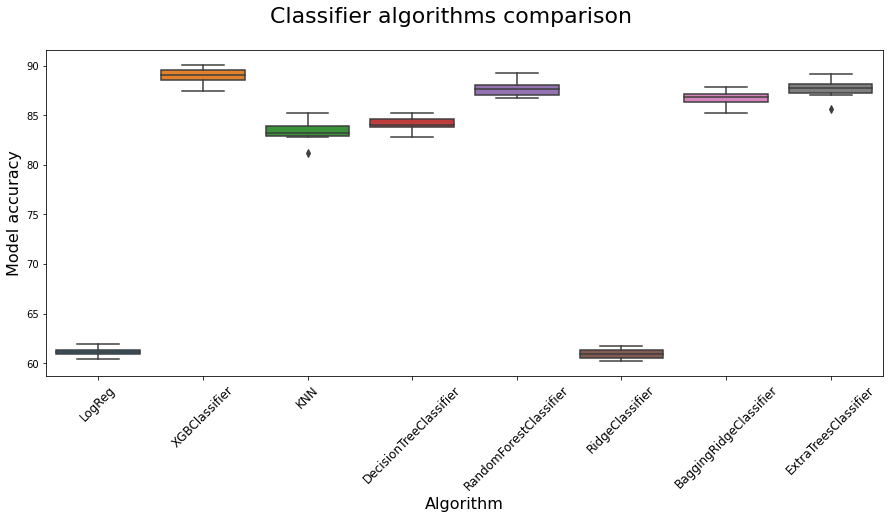

In [25]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier algorithms comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=16)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [26]:
classifier = XGBClassifier(random_state = 42)

In [27]:
# Get result from CV steps and apply 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accuracy: %.3f (%.3f) {accuracy_score(y_test, y_pred)}')

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\programdata\anaconda3\envs\phoenix\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2947  186]
 [ 423 1827]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3133
           1       0.91      0.81      0.86      2250

    accuracy                           0.89      5383
   macro avg       0.89      0.88      0.88      5383
weighted avg       0.89      0.89      0.89      5383

Accuracy: %.3f (%.3f) 0.8868660598179454


### Apply best model on "to_be_classifed" footprints in the area

In [28]:
classify_df = buildings_clust_df[buildings_clust_df.building_types == 'to_be_classified']

# Apply scaling
classify_scaled = scaler.transform(classify_df[['rectangularity','surface_area','building_block']])

yhat = classifier.predict(classify_scaled)
pd.DataFrame(yhat).value_counts()

0    47666
1    26341
dtype: int64

In [29]:
buildings_clust_df.building_block.value_counts().head()

-1      6257
1765    3462
1906    1374
1663    1203
596     1138
Name: building_block, dtype: int64

In [30]:
# Generate building block dataset for visualization (BEFORE)
block_id = '1765'
buildings_block_b4_df = buildings_clust_df[buildings_clust_df.building_block == block_id]
buildings_block_b4_df.building_types.value_counts()

to_be_classified     2462
accessory_storage     884
residential           112
commercial              2
public                  1
other                   1
Name: building_types, dtype: int64

In [31]:
# Before
buildings_clust_df['building_types'].value_counts()

to_be_classified     74007
residential          12587
accessory_storage     7562
accessory_supply       491
commercial             311
public                 249
industrial             205
other                  124
Name: building_types, dtype: int64

In [32]:
classify_df = classify_df.assign(building_types_pred = yhat)[['id','building_types_pred']]
# Only take those classified as "residential"
classify_df = classify_df[classify_df.building_types_pred == 1]

# Get list of OSM_ID 
residential_list = list(classify_df.id)
buildings_clust_df['building_types'] = np.where(buildings_clust_df.id.isin(residential_list), 'residential', buildings_clust_df.building_types)

In [33]:
# After
buildings_clust_df['building_types'].value_counts()

to_be_classified     47666
residential          38928
accessory_storage     7562
accessory_supply       491
commercial             311
public                 249
industrial             205
other                  124
Name: building_types, dtype: int64

#### Plot example block in the area

In [43]:
buildings_block_b4_df.building_types.value_counts().sort_index()

accessory_storage     884
commercial              2
other                   1
public                  1
residential           112
to_be_classified     2462
Name: building_types, dtype: int64

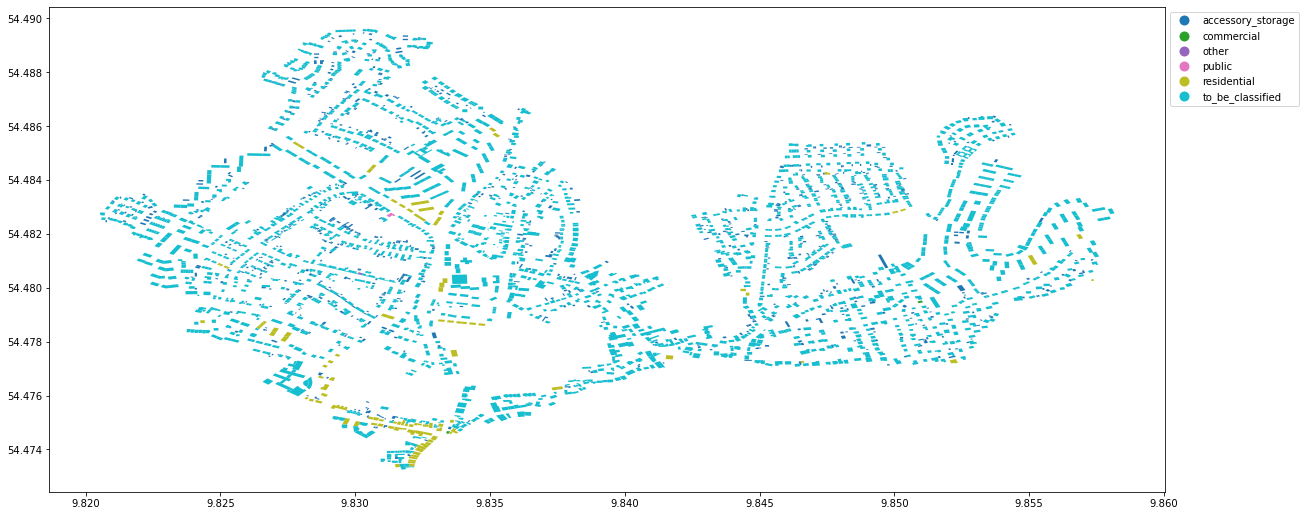

In [34]:
# BEFORE
bc.plot_buildings_area(buildings_block_b4_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

In [44]:
# Get example
buildings_block_df = buildings_clust_df[buildings_clust_df.building_block == block_id]
buildings_block_df.building_types.value_counts().sort_index()

accessory_storage     884
commercial              2
other                   1
public                  1
residential          1312
to_be_classified     1262
Name: building_types, dtype: int64

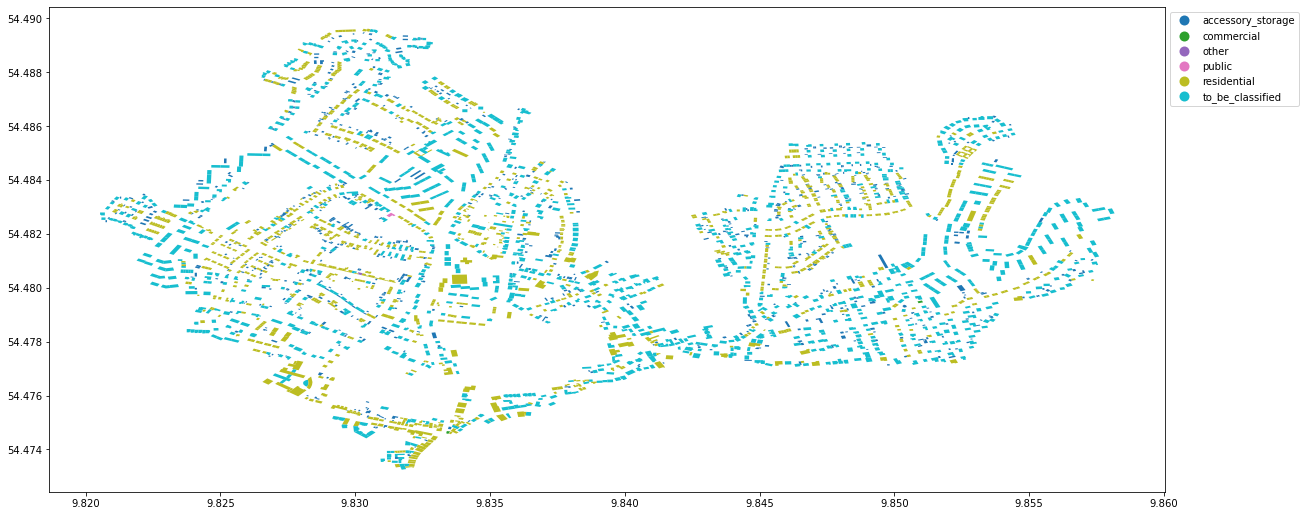

In [36]:
bc.plot_buildings_area(buildings_block_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

In [37]:
bc.generate_stats_table(buildings_block_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,884,52.574457,0.586076,0.149218,39.436912
1,commercial,2,112.101400,0.616071,0.004329,13.988650
2,other,1,113.811500,0.557349,0.000000,0.000000
3,public,1,247.565200,0.457312,0.000000,0.000000
4,residential,1312,113.831089,0.587651,0.128946,121.653679
5,to_be_classified,1262,201.375220,0.636740,0.151026,78.382769


___

In [50]:
def xgboost_classify_building(buildings_clust_df):
    """
    Classify building footprints into residential and non-residential. 
    Merge results with existing naive classification (from data_preparation pipeline)
    
    Args:
        buildings_clust_df: building footprints dataset for an area with building_block results from HDBSCAN
    
    """
    
    # Turn into a binary classification problem: residentials vs the rest
    df = buildings_clust_df[buildings_clust_df.building_types != 'to_be_classified'][['building_types', # target variable
                                                                                      'rectangularity',
                                                                                      'surface_area',
                                                                                      'building_block']]
    
    df['building_types'] = np.where(df.building_types != 'residential', 'non-residential','residential')
    
    # Factorize features
    df.building_types = pd.factorize(df['building_types'])[0]
    df.building_block = pd.factorize(df['building_block'])[0]
    
    # Splitting the data into independent and dependent variables
    X = df[['rectangularity',
           'surface_area',
           'building_block',
           ]].values

    y = df[['building_types']].values

    # Using Skicit-learn to split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit classifier
    classifier = XGBClassifier(eval_metric = 'logloss',use_label_encoder=False, random_state = 42)
    
    # Get result from CV steps and apply 
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    logging.info(f'Accuracy: %.3f (%.3f) {accuracy_score(y_test, y_pred)}')
    
    ########################################
    # Classify unknown footprints
    classify_df = buildings_clust_df[buildings_clust_df.building_types == 'to_be_classified']
    # Apply scaling
    classify_scaled = scaler.transform(classify_df[['rectangularity','surface_area','building_block']])
    yhat = classifier.predict(classify_scaled)
    
    classify_df = classify_df.assign(building_types_pred = yhat)[['id','building_types_pred']]
    # Only take those classified as "residential"
    classify_df = classify_df[classify_df.building_types_pred == 1]

    # Get list of OSM_ID 
    residential_list = list(classify_df.id)
    buildings_clust_df['building_types'] = np.where(buildings_clust_df.id.isin(residential_list), 'residential', buildings_clust_df.building_types)
    
    return buildings_clust_df

In [51]:
classified_buildings_df = xgboost_classify_building(buildings_clust_df)

2021-01-14 00:33:11,543 - root - INFO - Accuracy: %.3f (%.3f) 0.8895277522232444


# DEV

## Plot naive vs hdbscan result (1 AGS for Medium article example only)

In [40]:
# Plot settings
plt.rcParams['axes.facecolor'] = 'white'

In [41]:
# bc.plot_buildings_area(buildings_clust_df, 
#                        plot_type = 'building_block',
#                        legend_ncol = 2)